In [137]:
import requests
from bs4 import BeautifulSoup
import json
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, CategoricalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
import graphviz

# xG Model

## 1. Fetching data

### 1.1 Objects and functions to fetch data from Statsbomb's Github

In the third cell below, we call `fetch_matches_for_season` with argument **11**, as this corresponds to the La Liga comp in Statsbomb public data. See [here](https://github.com/statsbomb/open-data/blob/master/data/competitions.json).

In [17]:
class Game:
    """Game object whose only attribute is event-level JSON file (from Statsbomb's github)"""
    
    def __init__(self, json_file):
        self.json_file = json.loads(json_file)

In [18]:
def fetch_matches_for_season(github_season_url):
    """
    Function which take a url from Statsbomb's github for a specific season and returns a dictionary maping game ID's to the game's 
    event level JSON data.
    
    Arguments:
    
    github_season_url - (String) URL from Statsbomb's github. Format is:
                        https://github.com/statsbomb/open-data/blob/master/data/matches/{league_ID}/{season_ID}.json
    """
    req = requests.get(github_season_url).text
    soup = BeautifulSoup(req, "lxml") 
    table = soup.find('table')
    
    game_nums = []
    for td in table.find_all('td'):
        if "match_id" in td.text:
            game_num = re.findall(r'[0-9]+', td.text)[0]
            game_nums.append(game_num)
            
    json_files = []
    base_url_string = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/"
    game_num_dict = {
        game_num  : Game(requests.get(base_url_string + game_num + ".json").text)
        for game_num in game_nums
    }
 
    return game_num_dict

In [19]:
def fetch_all_seasons_for_league(competition_id):
    """
    Function which takes a competition_id, as specified by Statsbomb, and returns a dictionary where each season maps to 
    another dictionary containing all games in that season.
    
    Arguments:
    
    season_id - (int) competition_id as specified by Statsbomb 
                      See here: https://github.com/statsbomb/open-data/blob/master/data/competitions.json
    
    """
    #Get webpage html for competitions.json
    req = requests.get("https://raw.githubusercontent.com/statsbomb/open-data/master/data/competitions.json").text
    #Convert webpage to json format
    competitions_statsbomb = json.loads(req)

    all_seasons_id = {}
    for comps in competitions_statsbomb:
        if comps['competition_id'] == competition_id:
            season_id = comps['season_id']
            season_name = comps['season_name']
        
            all_seasons_id[season_name] = season_id
    
    league_all_games_by_seasons = {}
    
    for keys, values in all_seasons_id.items():
        season_url = "https://github.com/statsbomb/open-data/blob/master/data/matches/{}/{}.json".format(competition_id, values)
        print("Getting season {}...".format(keys))
        season = fetch_matches_for_season(season_url)
        league_all_games_by_seasons[keys] = season
    
    print("Done")
    
    return league_all_games_by_seasons

la_liga = fetch_all_seasons_for_league(11)

Getting season 2015/2016...
Getting season 2014/2015...
Getting season 2013/2014...
Getting season 2012/2013...
Getting season 2011/2012...
Getting season 2010/2011...
Getting season 2009/2010...
Getting season 2008/2009...
Getting season 2007/2008...
Getting season 2006/2007...
Getting season 2005/2006...
Getting season 2004/2005...
Done


So we have a data structure, called `la_liga`, which has league season names as the keys of the outer dictionary. The values are dictionaries, which map game ids (as specified by statsbomb) to `Game` objects (defined above).

### 1.2 Getting shots data 

Now I will write some functions to parse through the json of each game, and extract all the shots, as well as features related to the shots. In particular, these features are: 

- **play pattern**: pattern of play which led to the shot
- **x start location**: x-location of the shot 
- **y start location**: y-location of the shot 
- **duration**: duration of the shot
- **outcome**: result of the shot
- **technique**: technique with which the shot was hit
- **first time**: whether the shot was hit for time or not
- **x gk position**: x-location of the gk when shot was taken
- **y gk position**: y-location of the gk when shot was taken
- **type of shot**: whether shot was from open play or set piece (and type of set piece specified)
- **num opponents within 5 yards**: number of opponents which were within 5 yards of shot location
- **num opponents between shot and goal**: number of opponents which were between the shot location, and the lines connecting shot location and the two posts

All the variables listed above can be extracted by parsing through the json directly, except for the last one. Therefore, below, I will write a function to get this variable.

In [24]:
def check_player_btwn_shot_and_goal(x_shot, y_shot, x_player, y_player):
    """
    Function which checks whether a player in a stats bomb freeze is between the shot location, and the two lines
    connecting the shot location to the posts. See here for coordinate specifications: 
    https://github.com/statsbomb/open-data/blob/master/doc/StatsBomb%20Open%20Data%20Specification%20v1.1.pdf
    
    Arguments:
    x_shot    x-location of shot
    y_shot    y-location of shot
    x_player  x-location of player
    y_player  y-location of player    
    """
    x_diff = x_player - x_shot
    y_diff = y_player - y_shot
    
    if 120 - x_shot == 0:
        return False
    
    slope_1 = (36 - y_shot) / (120 - x_shot)
    slope_2 = (44 - y_shot) / (120 - x_shot) 
                    
    return (x_diff >= 0) and ((y_shot + slope_1 * x_diff) < y_player < (y_shot + slope_2 * x_diff))


def plot_shot_freeze_frame(game_json, shot_id):
    player_pos_list_x = []
    player_pos_list_y = []
    x_shot = 0
    y_shot = 0
    
    for events in game_json:
        if events['id'] == shot_id:
            x_shot = events['location'][0]
            y_shot = events['location'][1]
        
            for players in events['shot']['freeze_frame']:
                if (players['teammate'] == False):
                    player_pos_list_x.append(players['location'][0])
                    player_pos_list_y.append(players['location'][1])
            
    plt.scatter(player_pos_list_x, player_pos_list_y)
    plt.plot([x_shot, 120], [y_shot,36], color = 'red', linestyle = '--')
    plt.plot([x_shot, 120], [y_shot,44], color = 'red', linestyle = '--')

Now I will write a function which takes a json file for a given game, and returns a data frame containing all shots taken along with the variables related to that shot. Then I will write two wrapper function: `get_shots_for_season` which calls `get_shots_for_game` on all game files for that season, and `get_shots_for_league`, which does a similar thing, but for each game across every season we have for that league.

In [25]:
def get_shots_for_game(game_json):
    """
    Function which parses through a game JSON and return a data frame containing all shots taken in that game with several features 
    related to that shot
    
    Arguments
    game_json - event level json for a game
    """
    
    #features for each shot, which will be the columns of our data frame
    
    shot_id_list = []
    x_start_location_list = []
    y_start_location_list = []
    play_pattern_list = []
    duration_list = []
    outcome_list = []
    technique_list = []
    type_shot_list = []
    first_time_list = []
    x_gk_pos_list = []
    y_gk_pos_list = []
    num_opponents_5_yards_list = []
    num_opponents_between_goal_list = []
    
    #-------------------------#

    for events in game_json:
    
        if events['type']['name'] == 'Shot':
        
            #get data for first 8 features
            shot_id = events['id']
            x_start_location = events['location'][0]
            y_start_location = events['location'][1]
            play_pattern = events['play_pattern']['name']
            duration = events['duration']
            outcome = events['shot']['outcome']['name'] 
            technique = events['shot']['technique']['name']
            type_shot = events['shot']['type']['name']
        
            #check if json shot has a first_time attribute, if not set first_time to False
            if 'first_time' in events['shot']:
                first_time = events['shot']['first_time']
            else:
                first_time = False
            
            #check if shot has a freeze_frame dictionary
            if "freeze_frame" in events["shot"]:
                
                num_opponents_5_yards = 0
                num_opponents_between_goal = 0
                
                for player in events["shot"]["freeze_frame"]:
                    x_player = player['location'][0]
                    y_player = player['location'][1]
                    
                    #count how many opponents were within 5 yards of player when shot was taken
                    if ((x_start_location - x_player)**2 + (y_start_location - y_player)**2) <= 25 and (player['teammate'] == False):
                        if (player['position']['name'] != 'Goalkeeper'):
                            num_opponents_5_yards += 1
                    
                    #count how many opponents were between shot and goal
                    if (player['teammate'] == False) and (player['position']['name'] != 'Goalkeeper'):
                        if check_player_btwn_shot_and_goal(x_start_location, y_start_location, x_player, y_player):
                            num_opponents_between_goal += 1
                    
                    #get position of opponent's goalkeeper 
                    if ((player['position']['name'] == 'Goalkeeper') and (player['teammate'] == False)):
                        x_gk_pos = player['location'][0]
                        y_gk_pos = player['location'][1]
            
            #if there is no freeze frame, assume goalkeeper is at center of goal, and 0 opponenets around shot location
            else:
                num_opponents_between_goal = 0
                num_opponents_5_yards = 0
                x_gk_pos = 120
                y_gk_pos = 40            
            
            #append data on shot to relevant list (column)
            shot_id_list.append(shot_id)
            play_pattern_list.append(play_pattern)
            x_start_location_list.append(x_start_location)
            y_start_location_list.append(y_start_location)
            duration_list.append(duration)
            outcome_list.append(outcome)
            technique_list.append(technique)
            first_time_list.append(first_time)
            x_gk_pos_list.append(x_gk_pos)
            y_gk_pos_list.append(y_gk_pos)
            type_shot_list.append(type_shot)
            num_opponents_5_yards_list.append(num_opponents_5_yards)
            num_opponents_between_goal_list.append(num_opponents_between_goal)
        
    #create data frame with column features
    shot_df = pd.DataFrame({
                       "shot id" : shot_id_list,
                       "play pattern" : play_pattern_list, 
                       "x start location" : x_start_location_list, 
                       "y start location" : y_start_location_list,
                       "duration" : duration_list, 
                       "outcome" : outcome_list, 
                       "technique" : technique_list, 
                       "first time" : first_time_list,
                       "x gk position" : x_gk_pos_list,
                       "y gk position" : y_gk_pos_list,
                       "type of shot" : type_shot_list,
                       "num opponents within 5 yards" : num_opponents_5_yards_list,
                       "num opponents between shot and goal" : num_opponents_between_goal_list
                       })
    
    return shot_df.set_index("shot id")

**Wrapper functions:**

In [26]:
def get_shots_for_season(season_dict):
    """
    Takes a dictionary whichs maps game ids to Game objects, and calls get_shots_for_game() on each one.
    
    Arguments:
    season_dict - dictionary which maps game ids (string, as specified by statsbomb) to Game objects (defined above)
    """
    total_shot_df = pd.DataFrame()
    
    for keys, values in season_dict.items():
        shot_df = get_shots_for_game(values.json_file)
        total_shot_df = total_shot_df.append(shot_df)
        
    return total_shot_df


def get_shots_for_league(league_dict):
    """
    Takes a dictionary which maps season names to season dictionaries for a league, and calls get_shots_for_game() on each game.
    
    Arguments:
    league_dict - dictionary which maps season names to another dictionary. This inner dictionary maps 
    game ids (as specified by statsbomb) to Game objects (defined above)
    """
    total_shot_df = pd.DataFrame()
    
    for keys, values in league_dict.items():
        shot_df = get_shots_for_season(values)
        total_shot_df = total_shot_df.append(shot_df)
        print("Getting shots for " + keys)
    
    print("Done.")
    
    return total_shot_df

In [33]:
all_la_liga_shots = get_shots_for_league(la_liga)

Getting shots for 2015/2016
Getting shots for 2014/2015
Getting shots for 2013/2014
Getting shots for 2012/2013
Getting shots for 2011/2012
Getting shots for 2010/2011
Getting shots for 2009/2010
Getting shots for 2008/2009
Getting shots for 2007/2008
Getting shots for 2006/2007
Getting shots for 2005/2006
Getting shots for 2004/2005
Done.


So we have our data frame with all 8512 shots taken in Barca games from 2004/05 to 2015/16.

In [34]:
all_la_liga_shots

,play pattern,x start location,y start location,duration,outcome,technique,first time,x gk position,y gk position,type of shot,num opponents within 5 yards,num opponents between shot and goal
shot id,,,,,,,,,,,,
8522d7b1-8efd-4400-9006-1c2d1327f41d,Regular Play,109.7,30.6,0.564551,Off T,Normal,True,117.7,37.1,Open Play,2,1
fa3b6e06-dac2-4e77-81f7-20ff9429ad3a,From Throw In,87.5,31.7,1.201127,Off T,Normal,False,118.4,40.1,Open Play,2,1
b70b5409-5781-4182-b31a-bad2c8e3e891,From Goal Kick,107.1,34.0,0.466900,Saved,Normal,False,117.6,37.5,Open Play,6,1
e3fc1a0b-d68a-4ffb-95bf-4f97c075c049,From Corner,116.4,38.9,0.323872,Goal,Volley,True,119.7,38.5,Open Play,2,1
97b07723-77e9-4ece-aa90-b6c975b0dbc1,From Corner,97.5,33.8,0.268600,Wayward,Volley,True,119.3,40.0,Open Play,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
e05a628b-87f5-49b1-980a-71e3f8d59929,From Free Kick,114.9,37.3,0.703500,Goal,Normal,False,118.9,39.0,Open Play,5,0
0db9c930-e402-4ab3-bf98-bcd888b1acf7,Regular Play,108.4,25.7,0.596500,Blocked,Normal,True,115.2,32.7,Open Play,0,1
6ab038e3-9e39-4bb9-a823-6221d6a16542,Regular Play,114.0,39.6,0.296701,Blocked,Normal,False,115.0,35.1,Open Play,2,1


## 2. Data Exploration

### 2.1 Create new variables

We will create the following new variables:

- Distance of shot location from goal
- Convert outcome to a binary variable (Goal = 1, Other = 0)

In [35]:
all_la_liga_shots["Distance from goal"] = np.sqrt((all_la_liga_shots["x start location"] - 120)**2 +    \
                                                  (all_la_liga_shots["y start location"] - 40)**2)

goal_label_mask = all_la_liga_shots["outcome"].str.contains("Goal")
all_la_liga_shots["outcome"].loc[goal_label_mask] = 1
all_la_liga_shots["outcome"].loc[~goal_label_mask] = 0

/Users/robertblumberg/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [36]:
all_la_liga_shots

,play pattern,x start location,y start location,duration,outcome,technique,first time,x gk position,y gk position,type of shot,num opponents within 5 yards,num opponents between shot and goal,Distance from goal
shot id,,,,,,,,,,,,,
8522d7b1-8efd-4400-9006-1c2d1327f41d,Regular Play,109.7,30.6,0.564551,0,Normal,True,117.7,37.1,Open Play,2,1,13.944533
fa3b6e06-dac2-4e77-81f7-20ff9429ad3a,From Throw In,87.5,31.7,1.201127,0,Normal,False,118.4,40.1,Open Play,2,1,33.543107
b70b5409-5781-4182-b31a-bad2c8e3e891,From Goal Kick,107.1,34.0,0.466900,0,Normal,False,117.6,37.5,Open Play,6,1,14.227087
e3fc1a0b-d68a-4ffb-95bf-4f97c075c049,From Corner,116.4,38.9,0.323872,1,Volley,True,119.7,38.5,Open Play,2,1,3.764306
97b07723-77e9-4ece-aa90-b6c975b0dbc1,From Corner,97.5,33.8,0.268600,0,Volley,True,119.3,40.0,Open Play,2,1,23.338595
...,...,...,...,...,...,...,...,...,...,...,...,...,...
e05a628b-87f5-49b1-980a-71e3f8d59929,From Free Kick,114.9,37.3,0.703500,1,Normal,False,118.9,39.0,Open Play,5,0,5.770615
0db9c930-e402-4ab3-bf98-bcd888b1acf7,Regular Play,108.4,25.7,0.596500,0,Normal,True,115.2,32.7,Open Play,0,1,18.413310
6ab038e3-9e39-4bb9-a823-6221d6a16542,Regular Play,114.0,39.6,0.296701,0,Normal,False,115.0,35.1,Open Play,2,1,6.013319


### 2.2 Create a stratified training and test set

In [42]:
data_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
data_split_generator = data_split.split(all_la_liga_shots, all_la_liga_shots["outcome"])

for training_indices, test_indices in data_split_generator:
    shot_training_set = all_la_liga_shots_copy.iloc[training_indices]
    shot_test_set = all_la_liga_shots_copy.iloc[test_indices]

In [45]:
shot_training_set

,play pattern,x start location,y start location,duration,outcome,technique,first time,x gk position,y gk position,type of shot,num opponents within 5 yards,num opponents between shot and goal,Distance from goal
shot id,,,,,,,,,,,,,
af41bc3d-f586-402d-83f9-07e1e50913a3,Regular Play,108.7,22.2,0.316900,0,Normal,True,118.7,35.4,Open Play,1,0,21.083880
0683b203-c433-4825-845b-7c960d7c52e8,From Free Kick,107.4,49.2,0.841101,1,Half Volley,True,118.7,41.8,Open Play,1,2,15.601282
ab81c24c-c1bd-42b6-bf93-a7dc60502027,Regular Play,113.0,41.3,1.004000,0,Normal,False,119.4,39.9,Open Play,4,1,7.119691
a28252f8-fa43-432c-be76-b48ee1e4fcce,From Free Kick,103.4,44.7,1.052700,0,Normal,True,118.5,41.8,Open Play,2,1,17.252536
940ce10a-9b48-45bb-9989-05f604b4f81c,From Throw In,86.1,37.7,0.200800,0,Normal,False,114.7,40.5,Open Play,0,1,33.977934
...,...,...,...,...,...,...,...,...,...,...,...,...,...
d4975092-9732-49a5-a035-05bebdefc0a7,From Corner,94.7,38.2,0.553300,0,Half Volley,True,119.0,39.9,Open Play,2,3,25.363951
3fd1d661-766a-406e-b49a-672b483ffb90,From Keeper,97.1,33.7,0.584300,0,Normal,False,117.0,40.1,Open Play,2,1,23.750789
4ee965b4-8d6b-40b7-9caa-1b5453c92b36,Regular Play,107.1,43.4,0.472400,0,Lob,True,113.4,42.2,Open Play,1,0,13.340540


### 2.3 Visualizing relationships

Below, I write a function, `plot_percent_goal_vs_attr` to plot the percentage of goals scored by desired **categorical** variable.

In [46]:
def plot_percent_goal_vs_attr(attribute, type_chart = "line"):
    """
    Function which plots the percentage of goals scored by desired categorical attribute in our shot training set.
    
    Arguments
    attribute - (string) name of categorical attribute in shot training set data frame
    """
    shot_training_set_copy = shot_training_set.copy() 
    
    attr_x = attribute
    attr_y = "outcome"
    attr_agg = "shot id"
    attrs = [attr_x, attr_y, attr_agg]

    outcomes_by_attribute = shot_training_set_copy.reset_index()[attrs]   \
                            .groupby([attr_x, attr_y])               \
                            .count()                                 \
                            .unstack()                               \
                            .fillna(0)
    
    outcomes_by_attribute = outcomes_by_attribute[attr_agg].reset_index()
    outcomes_by_attribute["Percent Goal"] = outcomes_by_attribute[1] * 100  / outcomes_by_attribute.sum(axis = 1)
    outcomes_by_attribute = outcomes_by_attribute.rename(columns={0: 'No Goal', 1: 'Goal'})
    
    if type_chart == "line":
        chart = alt.Chart(outcomes_by_attribute).mark_line()
    elif type_chart == "bar":
        chart = alt.Chart(outcomes_by_attribute).mark_bar()
    
    chart = chart.encode(
        alt.X('{}:N'.format(attr_x), axis = alt.Axis(title = attr_x, labelAngle = 0)),
        alt.Y('Percent Goal:Q', axis = alt.Axis(title = 'Percent Goal'))
    ).properties(width = 850, height = 300, 
             title = "Percent Goal vs {}".format(attr_x)
    ).configure_axis(labelFontSize = 13, titleFontSize = 15
    ).configure_title(fontSize = 16)
    
    return chart

#### 2.3.1 Percent goals by num opponents between shot and goal

Now we can use our function to plot the desired variables:

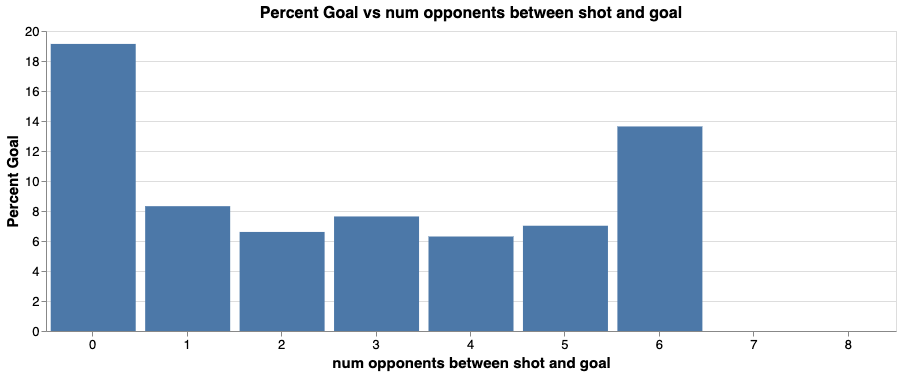

In [48]:
plot_percent_goal_vs_attr("num opponents between shot and goal", "bar")

**Comments:**

As expected, in general, the rate of goals scored decreases as more opponents are between the shot location and the goal. Interestingly, there is a bizarre peak at 6 opponents between shot and goal.

#### 2.3.2 Percent goals by num opponents within 5 yards

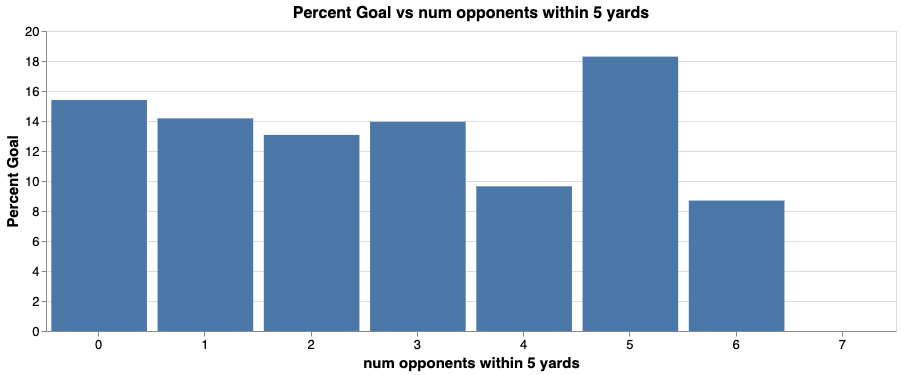

In [50]:
plot_percent_goal_vs_attr("num opponents within 5 yards", "bar")

**Comments:**

We see a similar trend for rate of goals scored vs number of opponents within 5 yards of shot location.

#### 2.3.3 Percent goals by player pattern

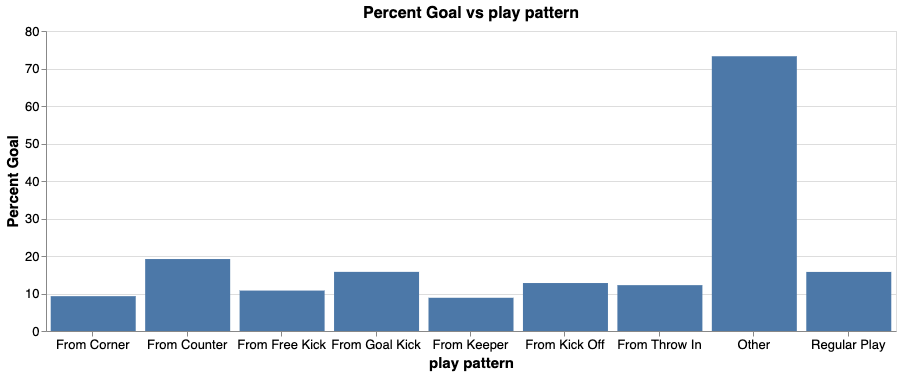

In [51]:
plot_percent_goal_vs_attr("play pattern", "bar")

**Comments:**

For goal scoring rate by _play pattern_, we see that "other" has a very large percent goals scored value. This tells us that "other" refers to penalties. Aside from "other", we can see that shots from counter attacks have a larger chance to produce a goal than any other play pattern, probably because counter attacks mean that the opposition is much less organized, resulting in more space. To be sure, we can check this below:

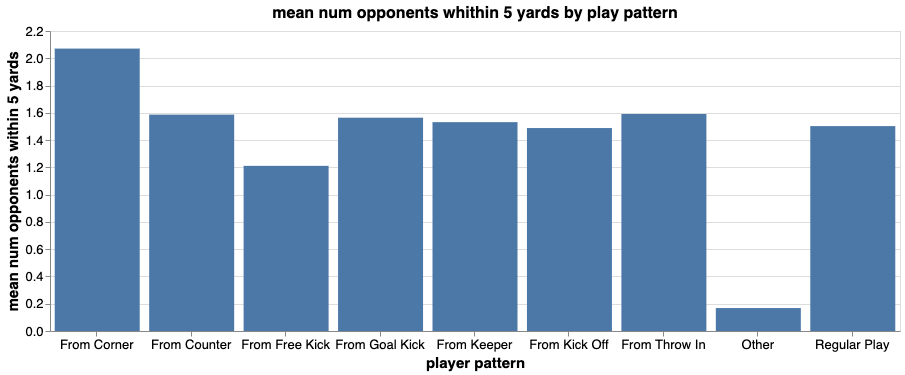

In [52]:
alt.Chart(shot_training_set.groupby("play pattern").mean().reset_index()).mark_bar().encode(
        alt.X('play pattern:N', axis = alt.Axis(title = "player pattern", labelAngle = 0)),
        alt.Y('num opponents within 5 yards:Q', axis = alt.Axis(title = 'mean num opponents within 5 yards'))
).properties(width = 850, height = 300, 
             title = "mean num opponents whithin 5 yards by play pattern"
).configure_axis(labelFontSize = 13, titleFontSize = 15
).configure_title(fontSize = 16)

Ok, so actually, shots resulting from counters, on average, don't have less players within 5 yards of the shot location than other play patterns. What about number of opponents between the shot location and the goal?

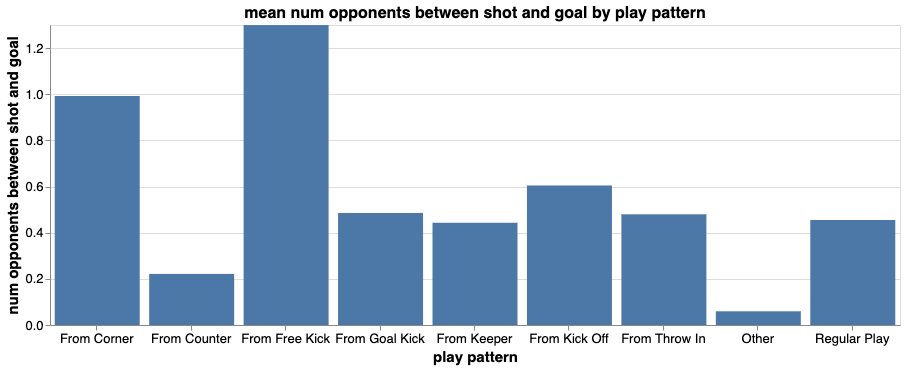

In [53]:
alt.Chart(shot_training_set.groupby("play pattern").mean().reset_index()).mark_bar().encode(
        alt.X('play pattern:N', axis = alt.Axis(title = "play pattern", labelAngle = 0)),
        alt.Y('num opponents between shot and goal:Q', axis = alt.Axis(title = 'num opponents between shot and goal'))
).properties(width = 850, height = 300, 
             title = "mean num opponents between shot and goal by play pattern"
).configure_axis(labelFontSize = 13, titleFontSize = 15
).configure_title(fontSize = 16)

Right, so we can see that actually, shots resulting from counters result in a higher rate of goals scored because there are less opponents between the shot location and the goal (on average), makes sense. 

#### 2.3.3 Percent goals by first time 

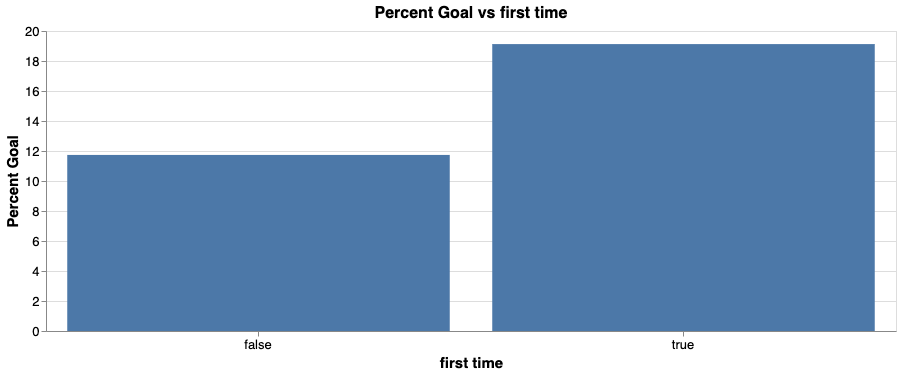

In [54]:
plot_percent_goal_vs_attr("first time", "bar")

## 3. Data preprocessing

We will create pipelines for preprocessing the categorical and numerical attributes in our shot data frame, then combine the two pipelines. To refresh our memories, here is the shot data frame again:

In [55]:
shot_training_set.head()

,play pattern,x start location,y start location,duration,outcome,technique,first time,x gk position,y gk position,type of shot,num opponents within 5 yards,num opponents between shot and goal,Distance from goal
shot id,,,,,,,,,,,,,
af41bc3d-f586-402d-83f9-07e1e50913a3,Regular Play,108.7,22.2,0.316900,0,Normal,True,118.7,35.4,Open Play,1,0,21.083880
0683b203-c433-4825-845b-7c960d7c52e8,From Free Kick,107.4,49.2,0.841101,1,Half Volley,True,118.7,41.8,Open Play,1,2,15.601282
ab81c24c-c1bd-42b6-bf93-a7dc60502027,Regular Play,113.0,41.3,1.004000,0,Normal,False,119.4,39.9,Open Play,4,1,7.119691
a28252f8-fa43-432c-be76-b48ee1e4fcce,From Free Kick,103.4,44.7,1.052700,0,Normal,True,118.5,41.8,Open Play,2,1,17.252536
940ce10a-9b48-45bb-9989-05f604b4f81c,From Throw In,86.1,37.7,0.200800,0,Normal,False,114.7,40.5,Open Play,0,1,33.977934


First, we create a class `AttrSelector`, which has methods `fit` and `transform` that we can use in our pipeline. This method will be use to select the features in our data frame for each pipeline.

Also, by making this class a subclass of `BaseEstimator` and `TransformerMixin`, we get the `fit_transform`, `get_params()` and `set_params()` methods as well.

In [56]:
class AttrSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attributes):
        self.attributes = attributes
   
    def fit(self, attributes):
        return self
    
    def transform(self, X):
        return X[self.attributes]

### 3.1 Categorical pipeline

In our categorical pipeline, we will use AttrSelector to select the relevant categorical attributes, stored as a list in the _categorical_shot_attributes_ variable. We then encode the values of each categorical variable as "One hot vector". 

In [57]:
categorical_shot_attributes = ["play pattern", "technique", "first time"]

categorical_attr_pipeline = Pipeline([
    ('selector', AttrSelector(categorical_shot_attributes)),
    ('one_hot_encoder',  OneHotEncoder())
])

In [58]:
one_hot_vals_play_pattern = shot_training_set["play pattern"].unique()
one_hot_vals_technique = shot_training_set["technique"].unique()
one_hot_vals_first_time = shot_training_set["first time"].unique()

one_hot_categorical_features = np.concatenate([one_hot_vals_play_pattern, one_hot_vals_technique, one_hot_vals_first_time])

### 3.2 Numerical pipeline

In our numerical pipeline, we will use AttrSelector to select the relevant numerical attributes, stored as a list in the _numerical_shot_attributes_ variable.

In [59]:
numerical_shot_attributes = ["x start location", "y start location", "x gk position", "y gk position", 
                             "num opponents within 5 yards", "num opponents between shot and goal", "Distance from goal"]

numerical_attr_pipeline = Pipeline([
    ('selector', AttrSelector(numerical_shot_attributes))
])

numerical_features = np.array(numerical_shot_attributes)

### 3.3 Combined pipeline

Now we combine the categorical and numerical pipelines using the `FeatureUnion` class. And we get our data frame transformed into a sparse matrix, ready to be passed through to sklearn models.

In [86]:
combined_pipeline = FeatureUnion(transformer_list = [
    ("categorical_attr_pipeline", categorical_attr_pipeline),
    ("numerical_attr_pipeline", numerical_attr_pipeline)
])

X_train = combined_pipeline.fit_transform(shot_training_set)
X_test = combined_pipeline.fit_transform(shot_test_set)

In [85]:
#list containing names of all features (including new one-hot features)
total_features = np.concatenate([one_hot_categorical_features, numerical_features])

In [91]:
y_train = shot_training_set["outcome"]
y_test = shot_test_set["outcome"]

## 4. Models

### 4.1 Decision tree

Now we are ready to create our model. The model will be a decision tree classifier, which will partition the training data at each step on a given feature and value. For example, if we choose "num player between shot and goal" as the feature, and 3 as the value, we will have two groups: one with all shots where "num player between shot and goal" $\leq3$ and one where "num player between shot and goal" $>3$. The goal at each step is to choose a feature and value that will create two groups that separate the labels as much as possible. In the ideal scenario, we could choose a feature/threshold that puts all shots which resulted in a goal in one group, and all shots which did not in the other, however, this of course will not be possible here. 

To quantify the quality of a split, sklearn's algorithm calculates a gini score for each split, defined as 

$Gini = \sum_{i=1}^C p_i(1-p_i)$, 

where $C$ is the number of classes (in this case 2) in a group, and $p_i$ is the probability of observing class $i$ in that group. The goal is to minimize the total $Gini$ for the two groups formed by the split. 

Once we've split the data once, we end up with two separate data sets, one which we repeat the same procedure. We can continue doing this until we get groups which are all homogeneous (only contain observations with the same label). However, this will result in a grossly overfitted model that will not generalize well, and so what we want to tell the DecisionTree model to stop splitting at some point. We can do this by specifying a _max_depth_ hyperparameter, which essentially tells the Decision tree the maximum number of times it can split the data before stopping. To determine the best _max_depth_ hyperparameter, I will calculate the accuracy for the training and test data as a function of different _max_depth_ values.

In [104]:
list_training_scores = []
list_test_scores = []
list_max_depth = range(1, 10)

for d in list_max_depth:
    tree_class = DecisionTreeClassifier(max_depth=d)
    tree_class.fit(X_train, y_train)
    training_score = tree_class.score(X_train, y_train)
    test_score = tree_class.score(X_test, y_test)    
    list_training_scores.append(training_score)
    list_test_scores.append(test_score)

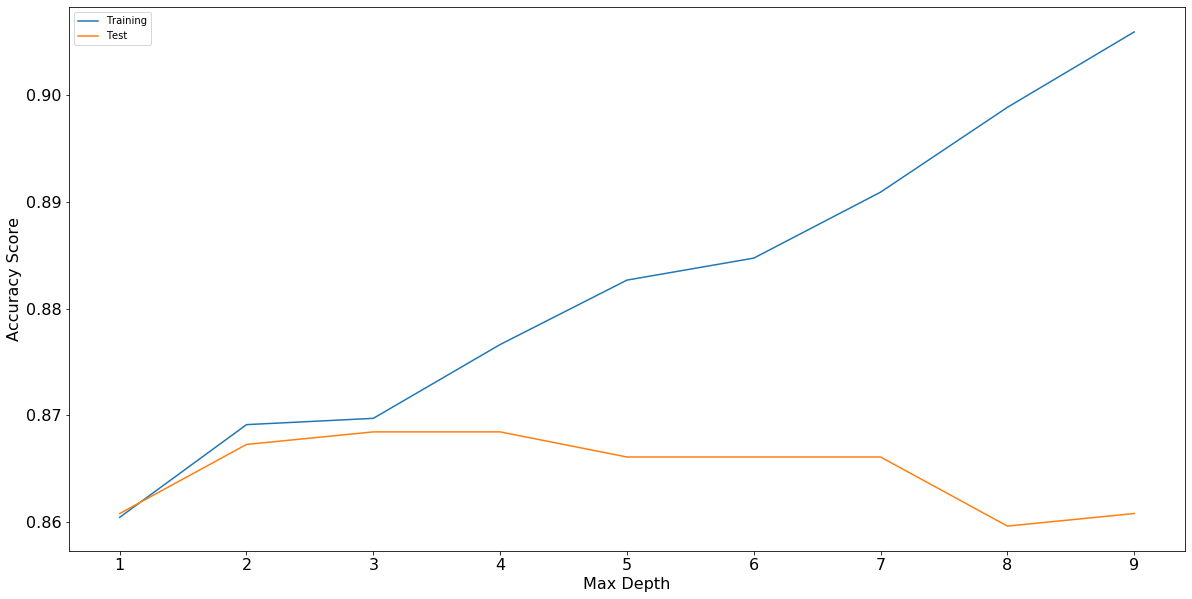

In [116]:
fig = plt.figure(figsize = (20,10))
plt.plot(list_max_depth, list_training_scores)
plt.plot(list_max_depth, list_test_scores)
plt.xlabel("Max Depth", size = 16)
plt.ylabel("Accuracy Score", size = 16)
plt.legend(["Training", "Test"])
plt.tick_params(labelsize = 16)

We can see, above, that after _max_depth_ = 3, we are beginning to overfit our data, resulting in a decreasing test accuracy score. So _max_depth_=3 seems to be a good value for this hyperparameter. Let's now train a decision tree with this value. First, below, I'll use a function which will allow us to visualize the tree. This function ... **Add accreditation** 

In [144]:
def save_and_show_decision_tree(model, 
                                class_names,
                                feature_names,
                                save_file_prefix = '../img/goal_decision_tree'):
    """
    Saves the decision tree model as a pdf and shows how the data is split and 
    classified

    Parameters
    ----------
    model: sklearn.tree.DecisionTreeClassifier
        The sklearn model decision tree
    class_names : list
        The names of all the possible classifications
    feature_names : list
        The names of all the features
    save_file_prefix: str
        The name you wish to save the file

    Returns
    -------
    graphviz.files.Source
        The decision tree graph
    """
    dot_data = tree.export_graphviz(model, out_file=None, 
                             feature_names=feature_names,  
                             class_names=class_names,  
                             filled=True, rounded=True,  
                             special_characters=True)  

    graph = graphviz.Source(dot_data) 
    graph.render(save_file_prefix) 
    return graph

**Fitting:**

In [147]:
tree_class = DecisionTreeClassifier(max_depth=3)
tree_class.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

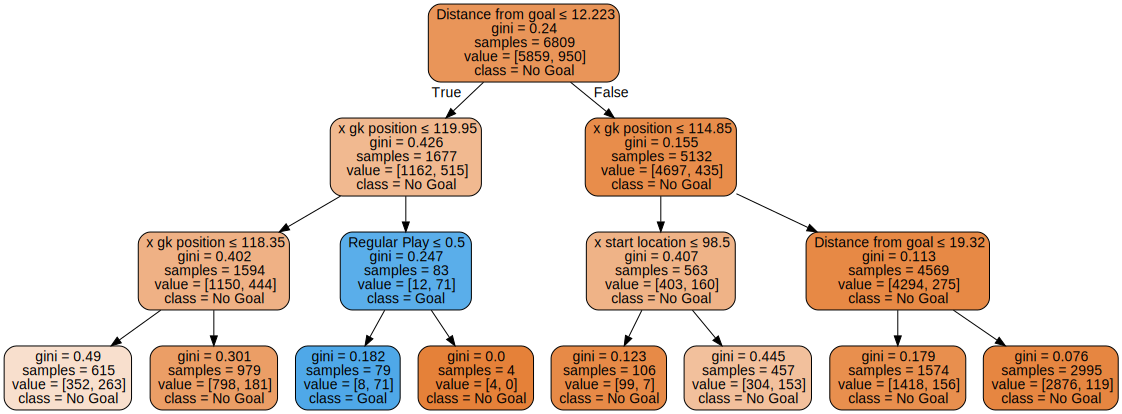

In [146]:
graph = save_and_show_decision_tree(tree_class,
                                    class_names = ["No Goal","Goal"],
                                    feature_names = total_features)
graph